In [1]:
!pip install rasterio raster2xyz

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 40.5 MB/s eta 0:00:00
  Created wheel for raster2xyz: filename=raster2xyz-0.1.3-py3-none-any.whl size=5946 sha256=53c6117cbec203ee0520fa291eb2ad38ab44c27859e1953a5f5a3396305bf55b
  Stored in directory: /root/.cache/pip/wheels/ef/5e/51/6df10cfc8d97148b3f46dd034ff2d748748d3b70ec53fbee69
Successfully built raster2xyz


In [2]:
import os
import rasterio
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

# PCA Imports
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn import metrics

# Visualizing data
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import matplotlib.patches as mpatches

In [3]:
# Connect to Google Drive
from google.colab import drive
drive.mount('/content/drive')

############## Update your 'mainDir' if your utlizing my code!!! ###############
# mainDir = "/content/drive/My Drive/.School/Capstone/"
################################################################################

################################################################################
# Using Shared Directory
# Be careful not to override others Checkpoints! => Make unique to your name
################################################################################
# Example:
# checkpoint_path = mainDir + 'model_checkpoints_{Your_Name_Here}/my_weights.weights.h5'
mainDir = "/content/drive/Shareddrives/Land_Classification_Training_shared/Land_Classification_training_work/"
################################################################################

# Define file paths
images_path = mainDir + "avirisng_sample_subset"
samples_path = mainDir + "valid_samples_1d/Samples_11_24_24/samples.csv" # Updated to use most recent samples

# NOTE: Only has final class name & Sample_num in this copy
labels_path = mainDir + "valid_samples_1d/Majority_Labeling_Cleaned.csv"

# DEFINE YOUR MODEL CHECKPOINT

# MY MODEL CHECKPOINT, PLEASE DO NOT USE IF TRAINING, ONLY FOR LOADING
################################################################################
checkpoint_path = mainDir + 'model_checkpoints_Ian/my_weights.weights.h5'
checkpoint_path_class_weights = mainDir + 'model_checkpoints_Ian/my_weights_with_cw.weights.h5'
################################################################################



# checkpoint_path = mainDir + '{YOUR_CHECKPOINT_PATH}'

Mounted at /content/drive


In [4]:
def load_data(samples_path, labels_path):
  samples_df = pd.read_csv(samples_path)
  labels_df = pd.read_csv(labels_path)
  # Extract sample number and store in column to use
  samples_df['Sample_num'] = samples_df['File'].str.split('_').str[0].astype(int)
  return samples_df, labels_df

In [5]:
def preprocess_data(samples_df, labels_df):
    # Clean up labels in both DataFrames (removing the extras in the names)
    labels_df['Class'] = labels_df['Class'].str.split('(').str[0].str.strip()
    samples_df['Label'] = samples_df['Label'].str.split('(').str[0].str.strip()

    # Remove rows with "Mixed or Not Classified"
    samples_df = samples_df[samples_df['Label'] != 'Mixed or Not Classified']
    labels_df = labels_df[labels_df['Class'] != 'Mixed or Not Classified']

    # Filter labels_df to include only Sample_num values present in samples_df
    labels_df = labels_df[labels_df['Sample_num'].isin(samples_df['Sample_num'])]

    # Reset the index after removing rows
    samples_df.reset_index(drop=True, inplace=True)
    labels_df.reset_index(drop=True, inplace=True)

    # Ensure unique labels match between samples_df and labels_df
    assert set(samples_df['Label'].unique()) == set(labels_df['Class'].unique()), "Mismatch in unique labels between samples_df and labels_df"

    # Define frequency columns
    frequency_columns = [col for col in samples_df.columns if col.startswith('frq')]

    # Replace NaNs with -9999.0 (if any remain)
    samples_df[frequency_columns] = samples_df[frequency_columns].fillna(-9999.0)

    # Remove rows where any frequency column is -9999.0
    samples_df = samples_df[~samples_df[frequency_columns].isin([-9999.0]).any(axis=1)]

    # Ensure labels_df only contains Sample_num present in samples_df
    labels_df = labels_df[labels_df['Sample_num'].isin(samples_df['Sample_num'])].reset_index(drop=True)

    # Verify that there are no -9999.0 values remaining
    assert not (samples_df[frequency_columns] == -9999.0).any().any(), "There are still -9999.0 values in the frequency columns after preprocessing."

    # Verify that all NaNs have been handled
    assert not samples_df[frequency_columns].isnull().any().any(), "There are still NaN values in the frequency columns after preprocessing."

    # Label Encoding for consistency
    label_encoder = LabelEncoder()
    samples_df['Label_Encoded'] = label_encoder.fit_transform(samples_df['Label'])

    return samples_df, labels_df, frequency_columns, label_encoder


In [6]:
def remove_wetlands(samples_df, labels_df):
  # Extract Sample_num from the File column in samples_df
  samples_df['Sample_num'] = samples_df['File'].str.split('_').str[0].astype(int)

  # Identify all Sample_num values associated with "Wetlands" in labels_df
  wetlands_samples = labels_df[labels_df['Class'].str.contains("Wetlands", na=False)]['Sample_num'].unique()

  # Remove rows in labels_df associated with "Wetlands"
  labels_df = labels_df[~labels_df['Sample_num'].isin(wetlands_samples)]

  # Remove rows in samples_df associated with the same Sample_num
  samples_df = samples_df[~samples_df['Sample_num'].isin(wetlands_samples)]

  # Verification
  # Check that no "Wetlands" labels remain in labels_df
  assert "Wetlands" not in labels_df['Class'].unique(), "Wetlands still present in labels_df."

  # Check that no rows with the removed Sample_num values are present in samples_df
  assert not samples_df['Sample_num'].isin(wetlands_samples).any(), "Wetlands samples still present in samples_df."

  print("Successfully removed 'Wetlands' from the dataset.")
  return samples_df, labels_df

In [7]:
def map_ground_truth(filtered_samples_df, labels_df):
  # Extract Sample_num from File column
  filtered_samples_df['Extracted_Sample_num'] = filtered_samples_df['File'].str.split('_').str[0].astype(int)

  # Create a mapping dict from labels_df using Sample_num and Class
  sample_class_mapping = labels_df.set_index('Sample_num')['Class'].to_dict()

  # Map Class values to filtered_samples_df based on Extracted_Sample_num
  filtered_samples_df['Ground_Truth'] = filtered_samples_df['Extracted_Sample_num'].map(sample_class_mapping)

  # Find mismatches between Label and Ground_Truth
  mismatches = filtered_samples_df[filtered_samples_df['Label'] != filtered_samples_df['Ground_Truth']]

  # Group by Extracted_Sample_num and Label to get count of pixels for each
  pixel_counts_df = filtered_samples_df.groupby(['Extracted_Sample_num', 'Label']).size().reset_index(name='Pixel_Count')

  # Merge the Ground_Truth based on Extracted_Sample_num
  pixel_counts_df = pixel_counts_df.merge(
      filtered_samples_df[['Extracted_Sample_num', 'Ground_Truth']].drop_duplicates(),
      on='Extracted_Sample_num',
      how='left'
    )

  return pixel_counts_df, mismatches

In [8]:
def verify_data_alignment(samples_df, labels_df, pixel_counts_df, mismatches, frequency_columns):
  """
  Verifies the alignment and consistency of data between samples_df, labels_df, and pixel_counts_df.
  Reports test status (pass/fail) for each verification step.
  """
  # Store test results
  test_results = []

  # Test 1: Ensure there are no mismatches between Label and Ground_Truth
  try:
    assert mismatches.empty, "Mismatches found between Label and Ground_Truth."
    test_results.append("Test 1: No mismatches between Label and Ground_Truth - PASSED :)")
  except AssertionError as e:
    test_results.append(f"Test 1: {str(e)} - FAILED :(")

  # Test 2: Ensure all Sample_num values in labels_df are present in pixel_counts_df
  missing_in_pixel_counts = set(labels_df['Sample_num']) - set(pixel_counts_df['Extracted_Sample_num'])
  try:
    assert len(missing_in_pixel_counts) == 0, "Sample_num values in labels_df but not in pixel_counts_df."
    test_results.append("Test 2: All Sample_num values in labels_df are present in pixel_counts_df - PASSED :)")
  except AssertionError as e:
    test_results.append(f"Test 2: {str(e)} - FAILED :(")

  # Test 3: Ensure there are no missing Sample_num values in samples_df (including oversampled data)
  missing_samples_check = samples_df[samples_df['Sample_num'].isin(missing_in_pixel_counts)]
  try:
    assert missing_samples_check.empty, "Entries in samples_df for missing Sample_num values."
    test_results.append("Test 3: No missing Sample_num values in samples_df - PASSED :)")
  except AssertionError as e:
    test_results.append(f"Test 3: {str(e)} - FAILED :(")

  # Test 4: Ensure all -9999.0 values have been removed from frequency columns
  negative_9999_count = (samples_df[frequency_columns] == -9999.0).sum().sum()
  try:
    assert negative_9999_count == 0, f"{negative_9999_count} instances of -9999.0 found in frequency columns."
    test_results.append("Test 4: No -9999.0 values in frequency columns - PASSED :)")
  except AssertionError as e:
    test_results.append(f"Test 4: {str(e)} - FAILED :(")

  # Test 5: Ensure the unique Sample_num counts between labels_df and samples_df are equal
  valid_sample_nums = samples_df['Sample_num'].unique()
  filtered_labels_df = labels_df[labels_df['Sample_num'].isin(valid_sample_nums)].reset_index(drop=True)

  print("\nNumber of unique Sample_num in samples_df:", len(valid_sample_nums))
  print("Number of unique Sample_num in labels_df:", filtered_labels_df['Sample_num'].nunique())

  try:
    assert filtered_labels_df['Sample_num'].nunique() == len(valid_sample_nums), (
      "Mismatch in unique Sample_num count between labels_df and samples_df."
    )
    test_results.append("Test 5: Unique Sample_num count matches between labels_df and samples_df - PASSED :)")
  except AssertionError as e:
    test_results.append(f"Test 5: {str(e)} - FAILED :(")

  # Test 6: Ensure oversampled data does not introduce invalid Sample_num values
  oversampled_sample_nums = samples_df['Sample_num'].unique()
  try:
    invalid_sample_nums = set(oversampled_sample_nums) - set(labels_df['Sample_num'])
    assert not invalid_sample_nums, f"Invalid Sample_num values introduced by oversampling: {invalid_sample_nums}"
    test_results.append("Test 6: Oversampling did not introduce invalid Sample_num values - PASSED :)")
  except AssertionError as e:
    test_results.append(f"Test 6: {str(e)} - FAILED :(")

  # Results
  print("\nVerification Results:")
  for result in test_results:
    print(result)


In [9]:
samples_df, labels_df = load_data(samples_path, labels_path)
remove_wetlands(samples_df, labels_df)

Successfully removed 'Wetlands' from the dataset.


(        Unnamed: 0      frq0      frq1      frq2      frq3      frq4  \
 0                0  0.018910  0.025453  0.026801  0.029931  0.025996   
 1                1  0.013469  0.015442  0.018657  0.021459  0.028462   
 2                2  0.013482  0.013153  0.018295  0.021435  0.028463   
 3                3  0.013058  0.024265  0.024345  0.023020  0.027349   
 4                4  0.015231  0.024812  0.023221  0.024547  0.028005   
 ...            ...       ...       ...       ...       ...       ...   
 398279          59  0.002211  0.011384  0.009327  0.016608  0.016334   
 398280          60  0.004726  0.014338  0.009449  0.016151  0.017545   
 398281          61  0.004768  0.011690  0.010392  0.015953  0.014548   
 398282          62  0.002905  0.012905  0.007541  0.014662  0.014470   
 398283          63  0.009146  0.010802  0.011206  0.012944  0.013535   
 
             frq5      frq6      frq7      frq8  ...    frq368    frq369  \
 0       0.030246  0.033545  0.035334  0.03959

In [10]:
print(samples_df)

        Unnamed: 0      frq0      frq1      frq2      frq3      frq4  \
0                0  0.018910  0.025453  0.026801  0.029931  0.025996   
1                1  0.013469  0.015442  0.018657  0.021459  0.028462   
2                2  0.013482  0.013153  0.018295  0.021435  0.028463   
3                3  0.013058  0.024265  0.024345  0.023020  0.027349   
4                4  0.015231  0.024812  0.023221  0.024547  0.028005   
...            ...       ...       ...       ...       ...       ...   
398279          59  0.002211  0.011384  0.009327  0.016608  0.016334   
398280          60  0.004726  0.014338  0.009449  0.016151  0.017545   
398281          61  0.004768  0.011690  0.010392  0.015953  0.014548   
398282          62  0.002905  0.012905  0.007541  0.014662  0.014470   
398283          63  0.009146  0.010802  0.011206  0.012944  0.013535   

            frq5      frq6      frq7      frq8  ...    frq368    frq369  \
0       0.030246  0.033545  0.035334  0.039591  ...  0.15808

In [11]:
labels_df

,Class,Sample_num
0,Unconsolidated Barren,1
1,Unconsolidated Barren,2
2,"Consolidated Barren (rocks, salt pans)",3
3,Annual Crops (e.g wheat),4
4,Annual Crops (e.g wheat),5
...,...,...
1805,Waterbodies,12048
1806,Waterbodies,12092
1807,Waterbodies,12108
1808,Waterbodies,12116


In [12]:
# Preprocess Data
samples_df, labels_df, frequency_cols, label_encoder = preprocess_data(samples_df, labels_df)

# Encode labels in the 'Label' column
label_encoder = LabelEncoder()
samples_df['Label_Encoded'] = label_encoder.fit_transform(samples_df['Label'])

# Ensure samples_df includes only the valid Sample_num values found in labels_df
valid_sample_nums = labels_df['Sample_num'].unique()
samples_df = samples_df[samples_df['Sample_num'].isin(valid_sample_nums)]

# Columns `frq0` to `frq372` are bands
frequency_cols = [col for col in samples_df.columns if 'frq' in col]
X = samples_df[frequency_cols].values  # 2D array where each row is a pixel's spectral data
y = samples_df['Label_Encoded']  # Use the filtered Ground Truth labels for each pixel

# Encode Ground_Truth labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

<ipython-input-5-457695c1ef0e>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  samples_df[frequency_columns] = samples_df[frequency_columns].fillna(-9999.0)
<ipython-input-5-457695c1ef0e>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samples_df['Label_Encoded'] = label_encoder.fit_transform(samples_df['Label'])


In [13]:
print(samples_df)

        Unnamed: 0      frq0      frq1      frq2      frq3      frq4  \
0                0  0.018910  0.025453  0.026801  0.029931  0.025996   
1                1  0.013469  0.015442  0.018657  0.021459  0.028462   
2                2  0.013482  0.013153  0.018295  0.021435  0.028463   
3                3  0.013058  0.024265  0.024345  0.023020  0.027349   
4                4  0.015231  0.024812  0.023221  0.024547  0.028005   
...            ...       ...       ...       ...       ...       ...   
274932          59  0.046806  0.051411  0.059857  0.063429  0.066798   
274933          60  0.046862  0.052788  0.061928  0.065137  0.069281   
274934          61  0.044689  0.049277  0.055507  0.061436  0.064873   
274935          62  0.047958  0.051963  0.058101  0.065782  0.067146   
274936          63  0.048413  0.051981  0.060076  0.066322  0.067937   

            frq5      frq6      frq7      frq8  ...    frq369    frq370  \
0       0.030246  0.033545  0.035334  0.039591  ...  0.16021

In [14]:
# Map Ground_Truth labels using the Sample_num (Used for testing)
pixel_counts_df, mismatches = map_ground_truth(samples_df, labels_df)

# Call the verification function after PreProcessing
test_results = verify_data_alignment(samples_df, labels_df, pixel_counts_df, mismatches, frequency_cols)

<ipython-input-7-4ebd5faace30>:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_samples_df['Extracted_Sample_num'] = filtered_samples_df['File'].str.split('_').str[0].astype(int)
<ipython-input-7-4ebd5faace30>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_samples_df['Ground_Truth'] = filtered_samples_df['Extracted_Sample_num'].map(sample_class_mapping)



Number of unique Sample_num in samples_df: 1450
Number of unique Sample_num in labels_df: 1450

Verification Results:
Test 1: No mismatches between Label and Ground_Truth - PASSED :)
Test 2: All Sample_num values in labels_df are present in pixel_counts_df - PASSED :)
Test 3: No missing Sample_num values in samples_df - PASSED :)
Test 4: No -9999.0 values in frequency columns - PASSED :)
Test 5: Unique Sample_num count matches between labels_df and samples_df - PASSED :)
Test 6: Oversampling did not introduce invalid Sample_num values - PASSED :)


In [15]:
# # Split Dataset
# X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

# # Model params
# # input_shape = (X_train.shape[1], 1)
# num_classes = len(label_encoder.classes_)

# # Convert labels to One-Hot Encoding
# y_train_cat = to_categorical(y_train, num_classes)
# y_test_cat = to_categorical(y_test, num_classes)

# Add a channel dimension for Conv1D
# X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
# X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [16]:
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_indices, test_indices = next(sss.split(samples_df['Sample_num'], samples_df['Label_Encoded']))

train_sample_nums = samples_df['Sample_num'].iloc[train_indices]
test_sample_nums = samples_df['Sample_num'].iloc[test_indices]

train_df = samples_df[samples_df['Sample_num'].isin(train_sample_nums)]
test_df = samples_df[samples_df['Sample_num'].isin(test_sample_nums)]

X_train = train_df[frequency_cols].values
y_train = train_df['Label_Encoded'].values
X_test = test_df[frequency_cols].values
y_test = test_df['Label_Encoded'].values

In [17]:
print(train_sample_nums)

76297     4812
92188     5092
61315     4015
34939     2402
145534    6462
          ... 
174771    7493
65452     4179
104548    5453
215683    8910
219665    9398
Name: Sample_num, Length: 208484, dtype: int64


In [18]:
print(test_sample_nums)

265633    11517
263903    11430
19720       491
125127     5773
264671    11471
          ...  
110541     5498
172684     7406
26201      1134
106443     5474
197866     8166
Name: Sample_num, Length: 52121, dtype: int64


In [19]:
print(X_train.shape, X_test.shape)  # Should show (num_train_samples, num_features)
print(y_train_cat.shape, y_test_cat.shape)  # Should show (num_train_samples, num_classes)

(260605, 373) (260600, 373)
(208484, 11) (52121, 11)


In [20]:
print(X_train[:10])

[[0.01890998 0.02545341 0.02680097 ... 0.16434297 0.17360443 0.19015998]
 [0.01346918 0.01544228 0.01865721 ... 0.15948851 0.15760055 0.16975044]
 [0.01348204 0.01315288 0.01829539 ... 0.16275653 0.15746768 0.16796441]
 ...
 [0.01834574 0.02379542 0.02707991 ... 0.17321828 0.17591667 0.17665653]
 [0.02253461 0.02572341 0.02978392 ... 0.1677511  0.17354141 0.18928549]
 [0.01906751 0.02041227 0.02765991 ... 0.15972975 0.15236509 0.18750647]]


In [21]:
# Flatten a 3D array (samples, features, channels) into 2D (samples, features * channels)
# X_train_flattened = X_train.reshape(X_train.shape[0], -1)
# X_test_flattened = X_test.reshape(X_test.shape[0], -1)

In [22]:
print("Variance before scaling:", np.var(X_train, axis=0)[:10])

Variance before scaling: [0.00075738 0.00082751 0.00092811 0.00103155 0.00111453 0.00118965
 0.00124046 0.00131081 0.00138202 0.00146862]


In [23]:
print(X_train.shape)

(260605, 373)


In [24]:
print(train_df['Label_Encoded'])

0         8
1         8
2         8
3         8
4         8
         ..
274932    9
274933    9
274934    9
274935    9
274936    9
Name: Label_Encoded, Length: 260605, dtype: int64


In [25]:
# from sklearn.feature_selection import VarianceThreshold
# selector = VarianceThreshold(threshold=0.0)
# X_train_var = selector.fit_transform(X_train)
# X_test_var = selector.transform(X_test)

# from sklearn.preprocessing import RobustScaler
# scaler = RobustScaler()
# X_train_scaled = scaler.fit_transform(X_train_var)
# X_test_scaled = scaler.transform(X_test_var)
# print("Variance after scaling:", np.var(X_train_scaled, axis=0))

In [26]:
# Remove 0 variance features
from sklearn.feature_selection import VarianceThreshold
selector = VarianceThreshold(threshold=0.0)
X_train_var = selector.fit_transform(X_train)
X_test_var = selector.transform(X_test)

# Check for 0 variance features
variances = np.var(X_train, axis=0)
zero_variance_features = np.where(variances == 0)[0]
print(f"Zero variance features at indices: {zero_variance_features}")

# Handle outliers by sacling using RobustScaler
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train_var)
X_test_scaled = scaler.transform(X_test_var)

# Check variance after scaling
print("Variance after scaling:", np.var(X_train_scaled, axis=0))

Zero variance features at indices: []
Variance after scaling: [3.51256014 3.56200051 3.54444106 3.62837175 3.53138043 3.46365881
 3.34272419 3.13864504 2.92648251 2.72698382 2.58286233 2.44679584
 2.32338937 2.23130451 2.15944943 2.11449507 2.04727929 1.99159533
 1.94914552 1.89254342 1.83233174 1.76870585 1.72434874 1.67566002
 1.63198196 1.59869893 1.57076468 1.54351109 1.52369986 1.49789321
 1.45898914 1.41930656 1.37817397 1.33545284 1.28914675 1.2307357
 1.1770985  1.11537881 1.06681394 1.02227508 0.99200771 0.96546715
 0.94254461 0.92135277 0.90469034 0.88761305 0.87359857 0.86321046
 0.85381008 0.84836634 0.83946774 0.83094763 0.82257027 0.8163039
 0.81149764 0.80890384 0.80615194 0.8120095  0.80462144 0.8003396
 0.7960723  0.80153481 0.82473043 0.8507641  0.87560346 0.8938379
 0.8704085  0.85870995 0.8731213  0.88512241 0.89260425 0.88951766
 0.88809055 0.88593607 0.883716   0.88558969 0.8789611  0.87699074
 0.87524641 0.87428041 0.87199654 0.87031636 0.86854394 0.86803883
 0.8

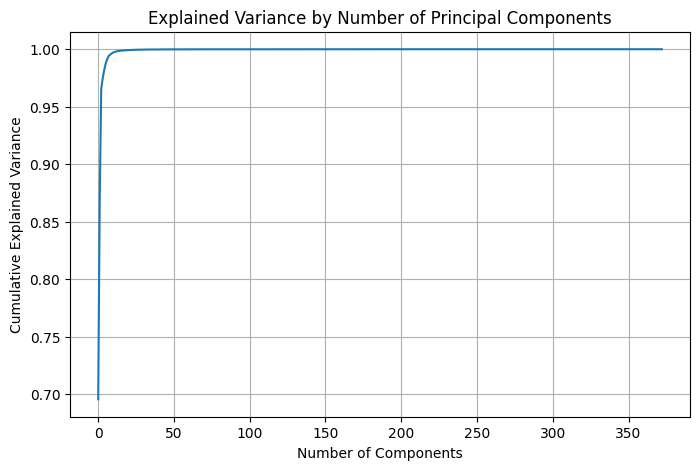

Number of components to retain 95% variance: 3
Shape of PCA-reduced data: (260605, 3)


In [27]:
pca = PCA()
X_pca = pca.fit_transform(X_train_scaled)

explained_variance = pca.explained_variance_ratio_

plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(explained_variance))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Number of Principal Components')
plt.grid()
plt.show()

pca_95 = PCA(n_components=0.95)
X_pca_95 = pca_95.fit_transform(X_train_scaled)

print(f"Number of components to retain 95% variance: {pca_95.n_components_}")

print("Shape of PCA-reduced data:", X_pca_95.shape)


In [28]:
print(pca.explained_variance_ratio_[:10])

[0.69560828 0.1740806  0.09617901 0.00909123 0.00719005 0.00578416
 0.00357341 0.00277969 0.00107303 0.00105257]


In [29]:
# Define pipelines for each model
pipelines = {
    'Logistic Regression': Pipeline([
        ('scaler', StandardScaler()),           # Step 1: Standardize data
        ('pca', PCA(n_components=3)),        # Step 2: PCA
        ('clf', LogisticRegression(random_state=42, max_iter=10000))  # Step 3: Logistic Regression
    ]),
    'KNN': Pipeline([
        ('scaler', StandardScaler()),           # Step 1: Standardize data
        ('pca', PCA(n_components=3)),        # Step 2: PCA
        ('clf', KNeighborsClassifier(n_neighbors=100))  # Step 3: KNN with 100 neighbors
    ])
}

Logistic Regression Accuracy: 0.60


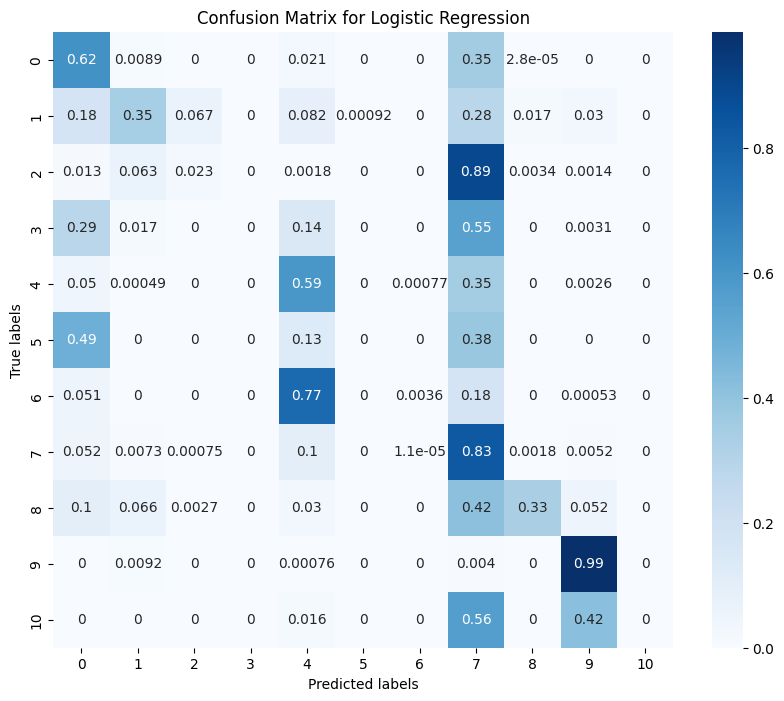

KNN Accuracy: 0.67


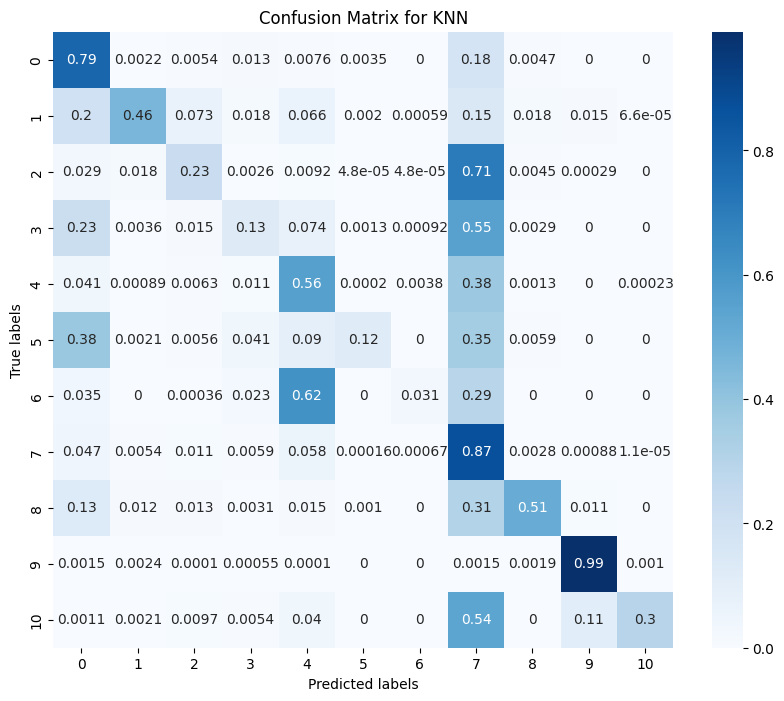

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.79      0.71     35169
           1       0.85      0.46      0.60     15250
           2       0.62      0.23      0.34     20759
           3       0.48      0.13      0.20     15298
           4       0.62      0.56      0.59     34883
           5       0.66      0.12      0.20      3374
           6       0.45      0.03      0.06      5625
           7       0.61      0.87      0.72     92287
           8       0.81      0.51      0.62      8033
           9       0.98      0.99      0.99     28990
          10       0.87      0.30      0.44       932

    accuracy                           0.67    260600
   macro avg       0.69      0.45      0.50    260600
weighted avg       0.67      0.67      0.64    260600



In [30]:
results = {}
for name, pipeline in pipelines.items():
    # Train
    pipeline.fit(X_train_var, y_train)

    # Predict on test data
    y_pred = pipeline.predict(X_test_var)

    # Get accuracy
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy
    print(f"{name} Accuracy: {accuracy:.2f}")

    # CM
    confusion = metrics.confusion_matrix(y_test, y_pred, normalize='true')

    plt.figure(figsize=(10, 8))
    sns.heatmap(confusion, annot=True, cmap='Blues',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(f'Confusion Matrix for {name}')
    plt.show()

# Classification report for model

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=[str(cls) for cls in label_encoder.classes_]))

In [31]:
def select_specific_components(pipeline, X):
    # Perform PCA transformation and get the transformed data
    X_pca = pipeline.named_steps['pca'].transform(X)

    # Select the 2nd, 3rd, and 4th components (index 1, 2, 3)
    return X_pca[:, [1, 2, 3]]

# Define pipelines for each model
pipelines = {
    'Logistic Regression': Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA()),
        ('clf', LogisticRegression(random_state=42, max_iter=10000))
    ]),
    'KNN': Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA()),
        ('clf', KNeighborsClassifier(n_neighbors=100))
    ])
}

In [ ]:
results = {}
for name, pipeline in pipelines.items():
    # Train
    pipeline.fit(X_train_var, y_train)
    X_transformed = select_specific_components(pipeline, X_test_var)

    # Predict on test data
    y_pred = pipeline.predict(X_test_var)

    # Get accuracy
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy
    print(f"{name} Accuracy: {accuracy:.2f}")

    # CM
    confusion = metrics.confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(10, 8))
    sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(f'Confusion Matrix for {name}')
    plt.show()

# Classification report for model

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=[str(cls) for cls in label_encoder.classes_]))

In [ ]:
import time
from sklearn.model_selection import GridSearchCV

param_grid = {'n_neighbors': list(range(1, 31))}
knn = KNeighborsClassifier()

start_time = time.time()
grid_search = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy')
grid_search.fit(X_train_var, y_train)
end_time = time.time()

print("Grid search took", end_time - start_time, "seconds")

results = grid_search.cv_results_


plt.plot(param_grid['n_neighbors'], results['mean_test_score'])
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')
plt.title('Grid Search for KNN Optimization')
plt.show()

print("Best k: ", grid_search.best_params_['n_neighbors'])
print("Best accuracy: ", grid_search.best_score_)

In [ ]:
param_grid = {'n_neighbors': list(range(31, 100))}
knn = KNeighborsClassifier()

start_time = time.time()
grid_search = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy')
grid_search.fit(X_train_var, y_train)
end_time = time.time()

print("Grid search took", end_time - start_time, "seconds")

results = grid_search.cv_results_


plt.plot(param_grid['n_neighbors'], results['mean_test_score'])
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')
plt.title('Grid Search for KNN Optimization')
plt.show()

print("Best k: ", grid_search.best_params_['n_neighbors'])
print("Best accuracy: ", grid_search.best_score_)

In [ ]:
param_grid = {'n_neighbors': list(range(100, 1000))}
knn = KNeighborsClassifier()

start_time = time.time()
grid_search = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy')
grid_search.fit(X_train_var, y_train)
end_time = time.time()

print("Grid search took", end_time - start_time, "seconds")

results = grid_search.cv_results_


plt.plot(param_grid['n_neighbors'], results['mean_test_score'])
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')
plt.title('Grid Search for KNN Optimization')
plt.show()

print("Best k: ", grid_search.best_params_['n_neighbors'])
print("Best accuracy: ", grid_search.best_score_)